# Micrograd

Micrograd is a tiny Autograd engine to demonstrate backpropagation in reverse auto-diff mode.

Backpropagation is just an application of the chain-rule of differentiation.     
It does not care about neural networks.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
 
from micrograd_utils import draw_dot

H = 0.000001

### Derivative of a simple function with one input

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

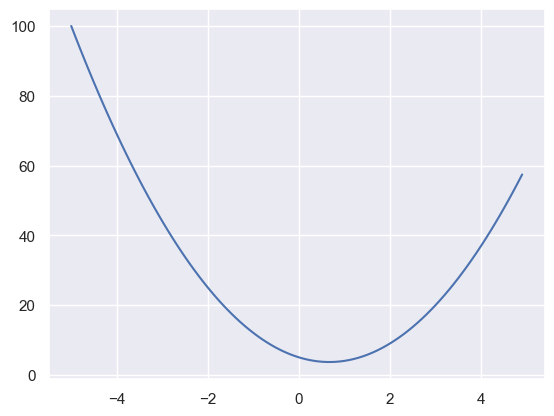

In [4]:
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys);

In [5]:
# Numerical derivative of the function.
x = 3.0
del_f = (f(x+H) - f(x)) / H
print(f"df/dx@3.0 = {del_f:.4f}")

print("\nAnalytical derivative of the function:\n",
      "df/dx = 6x-4\n", 
      "df/dx@3.0 = 6(3)-4 = 14\n",
      "=> Close enough.\n")

df/dx@3.0 = 14.0000

Analytical derivative of the function:
 df/dx = 6x-4
 df/dx@3.0 = 6(3)-4 = 14
 => Close enough.



In [6]:
# Make more complex.
a, b, c = 2.0, -3.0, 10.0
d = a*b+c
print(d)

4.0


In [7]:
# Compute derivatives of d wrt a,b,c.
def d_(a,b,c):
    return a*b+c

dd_da = (d_(a+H,b,c) - d_(a,b,c)) / H
print(f"dd/da = {dd_da:.4f}")

dd_db = (d_(a,b+H,c) - d_(a,b,c)) / H
print(f"dd/db = {dd_db:.4f}")

dd_dc = (d_(a,b,c+H) - d_(a,b,c)) / H
print(f"dd/dc = {dd_dc:.4f}")

dd/da = -3.0000
dd/db = 2.0000
dd/dc = 1.0000


### The `Value` class

In [82]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        """
        data is the value of the node.
        _prev tracks the parents of the node in the computational graph.
        _op tracks the operations which created the node from the parents.
        _backward is a function that performs backprop locally given the inputs and outputs at a node.
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # Default backward pass to no-op, say for leaf nodes.
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        """
        __repr__() is a Python magic method that returns a printable representation of the object.
        """
        return f"Value(label={self.label}, data={self.data})"

    def __add__(self, other):
        """
        __add__() defines the behavior of the addition operator (+).
        """
        out = Value(self.data + other.data, _children=(self, other), _op="+")

        def _backward():
            #self.grad = 1.0 * out.grad
            # Accumulate gradients instead of setting them, to account for the same node being used multiple times,
            # to allow for multiple backward passes through multiple paths in the computational graph.
            self.grad += 1.0 * out.grad
            #other.grad = 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        """
        __mul__() defines the behavior of the multiplication operator (*).
        """
        out = Value(self.data*other.data, _children=(self, other), _op="*")
        
        def _backward():
            #self.grad = other.data * out.grad
            self.grad += other.data * out.grad
            #other.grad = self.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        """
        tanh can also be built out of primitive ops after defining how exp works.
        However, we don't necessarily have to implement every primitive and
        exhaustively build things up bottom-up.
        As long as we know how to take the derivative of the function,
        we can implement any arbitrary function that we want.
        """
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op="tanh")

        def _backward():
            #self.grad = (1 - t**2) * out.grad
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

      
    def backward(self):
        """
        Public backward function to call _backward on each node in the graph
        in topologically sorted order.
        """
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


### Forward pass on a simple function.

In [9]:
# Test __add__.
a, b = Value(2., label="a"), Value(-3., label="b")
add1 = a+b
add2 = a.__add__(b)
assert add1.data == add2.data, "Error in data elements of __add__"
assert add1.__class__==add2.__class__, "Error in object type elements of __add__"

#Test __mul__.
c = Value(10., label="c")
e = a*b; e.label="e"
mul1 = e+c
mul2 = a.__mul__(b).__add__(c)
assert mul1.data == mul2.data, "Error in data elements of __mul__"
assert mul1.__class__==mul2.__class__, "Error in object type elements of __mul__"

d = a*b+c; d.label="d"

f = Value(-2.0, label="f")
L = d*f; L.label="L"
L

d = Value(label=d, data=4.0)
d._prev = {Value(label=c, data=10.0), Value(label=, data=-6.0)}
d._op=+
Thus, d has knowledge of what op was used to create it (+) and by operating on which 'Values' (a*b and c).


Value(label=L, data=-8.0)

In [14]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(label=L, data=-8.0)

### Visualize the forward pass.

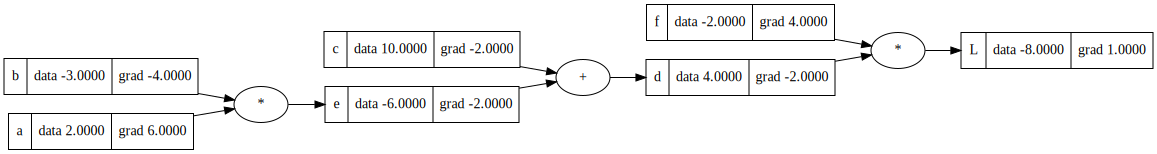

In [17]:
draw_dot(L)

### The (Manual) Backward pass.

In [22]:
# Manual backpropagation requires setting dL/dL=1.0 manually.
done_once = True

# These were computed by hand using the chain rule.
if done_once is False:
    L.grad = 1.0

    f.grad = 4.0
    d.grad = -2.0

    c.grad = -2.0
    e.grad = -2.0

    a.grad = 6.
    b.grad = -4.

# Nudge each parameter in the direction of the gradient.
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Compute another forward pass.
e = a * b
d = e + c
L = d * f

# Watch L move in the positive direction.
print(L.data)



-7.286496


In [19]:
def lol():
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += H
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/H)
  
lol()

-4.000000000559112


### Manual Backpropagation on a neuron.

![cs231n-neuron](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

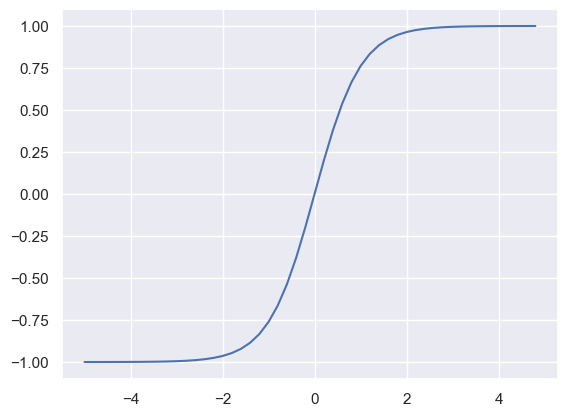

In [32]:
# Non-linear activation.
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));

In [79]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

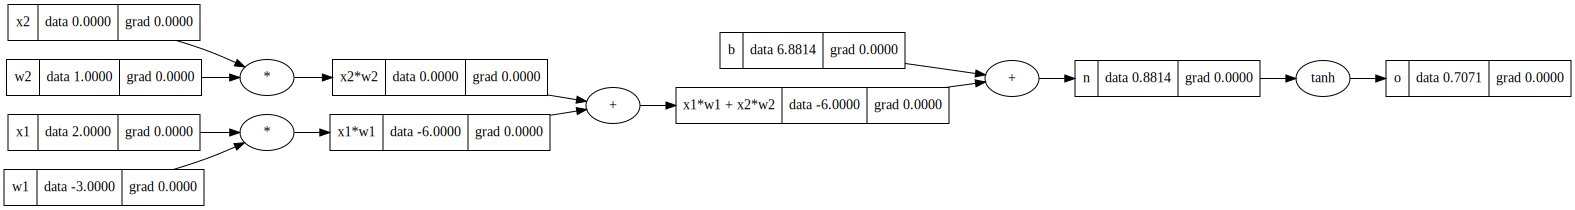

In [56]:
draw_dot(o)

In [46]:
# Compute gradients by hand.
o.grad = 1.0

n.grad = 1-o.data**2 # derivative of tanh is 1-tanh^2

x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

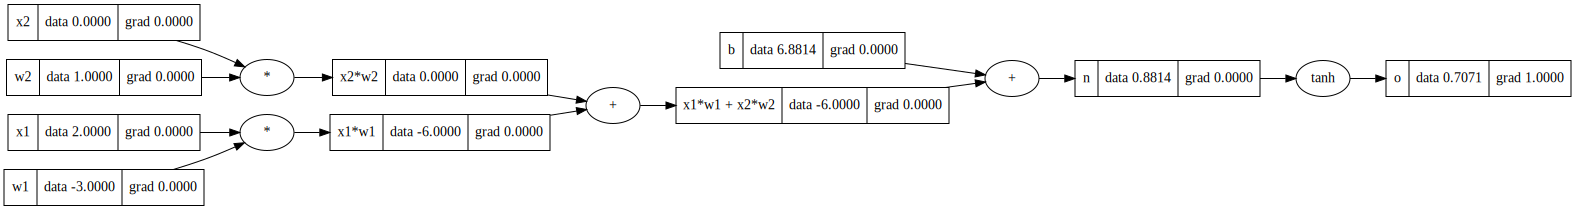

In [58]:
# After adding _backward() to all the ops in Value, we can now call backward() on the output.
o.grad = 1.0 # Was set to 0.0 by convention.
draw_dot(o)

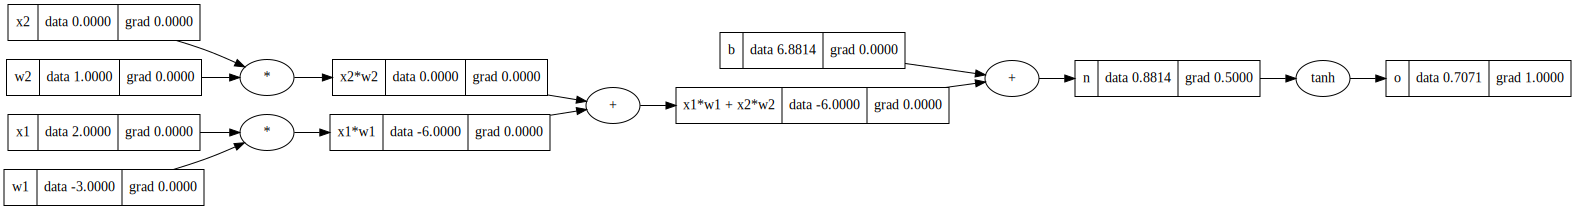

In [59]:
o._backward()
draw_dot(o)

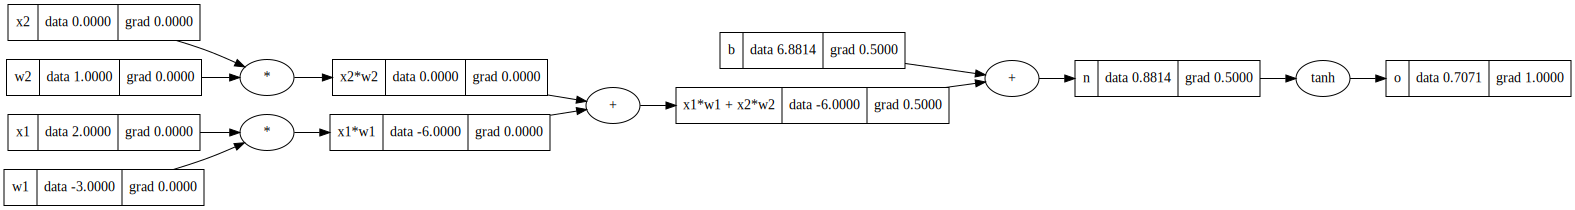

In [60]:
n._backward()
draw_dot(o)

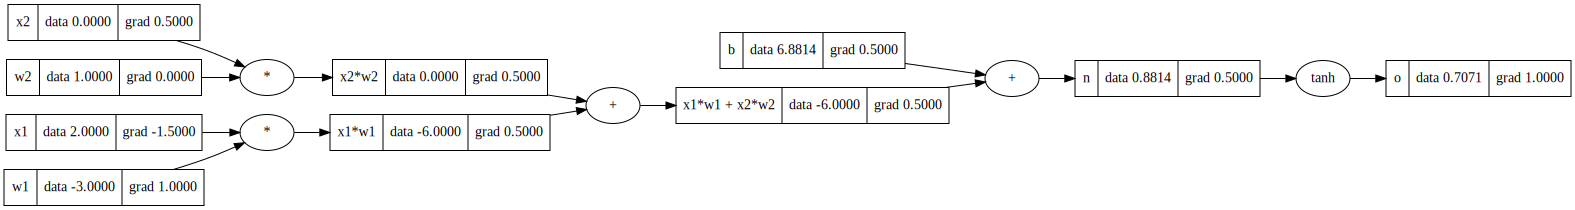

In [67]:
x1w1x2w2._backward()
# Nothing will happen for b, since it's a bias and it's backward is initialized to a no-op.
b._backward()
draw_dot(o)

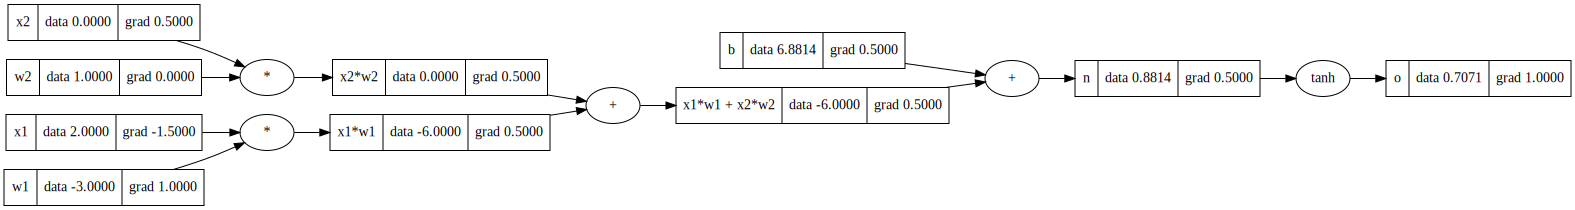

In [68]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

We have to make sure that gradient computation only happens right to left (from output to input).    
Thus, all dependencies will be pre-computed.    
=> This is a case for applying topological sort.

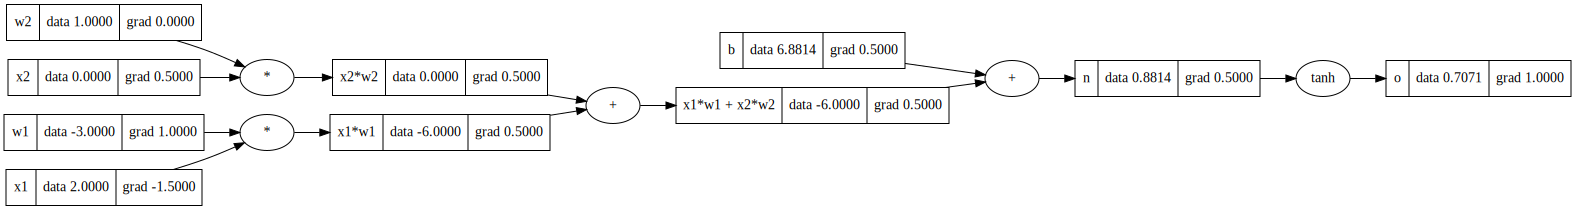

In [81]:
o.backward()
draw_dot(o)

We have not yet accounted for the same variable being used more than once.    
This can be solved by accumulating the gradients (fixed in `Value`).

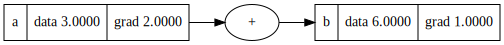

In [83]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

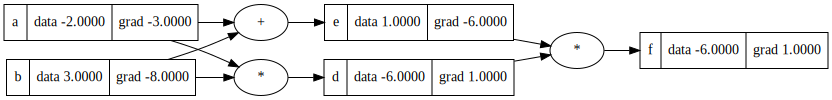

In [84]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()
draw_dot(f)